https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost

In [1]:
# Load Python libraries
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# Load data
df = pd.read_csv('input/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [3]:
# Load and join songs data
songs = pd.read_csv('input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73534 non-null object
source_screen_name        69517 non-null object
source_type               73550 non-null object
target                    73774 non-null int64
song_length               73772 non-null float64
genre_ids                 72611 non-null object
artist_name               73772 non-null object
composer                  56803 non-null object
lyricist                  41689 non-null object
language                  73771 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44037 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(2), int64(6), o

In [5]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.325318
source_screen_name         5.770326
source_type                0.303630
target                     0.000000
song_length                0.002711
genre_ids                  1.576436
artist_name                0.002711
composer                  23.004039
lyricist                  43.490932
language                   0.004066
city                       0.000000
bd                         0.000000
gender                    40.308239
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=,I6cPsYnhiNRQOADF6/7Qao+xuC57H5i39hqqgzGqwZs=,my library,Local playlist more,local-library,1,240419.0,465,John Newman,unknown,...,male,3,2016-03-06,2017-08-11,2016,3,6,2017,8,11
1,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,F5hqzPn/b7gPZX3CNvKaRvvZBQDgSpM1spwHOM/Qu1U=,my library,Local playlist more,local-library,1,281495.0,465,梁靜茹 (Fish Leong),unknown,...,female,9,2013-09-12,2017-09-12,2013,9,12,2017,9,12
2,my1bJaiDsy5D+/leKCQOvAuY1uNVVM1dzAXN1z7kd9g=,DNUVIVThZnYGuKKhy0RnyUmw9jDWb2/zCv6/14wC4qA=,my library,Local playlist more,local-library,1,274599.0,465,吳亦凡 (Kris Wu),宋秉洋,...,female,9,2008-04-13,2017-10-02,2008,4,13,2017,10,2
3,NAIo8bFZpUxl9BOwUfWiN+GWfozOiUPWzt3VGA7UpeE=,gr6pXoiiCkTnJgdQiy9TnGJz+8m1rbmiqY3ePB8PX/U=,discover,unknown,top-hits-for-artist,0,238027.0,465,八三夭 (The Last Day of Summer 831),八三夭 阿璞,...,female,3,2014-10-15,2017-10-06,2014,10,15,2017,10,6
4,ADYzhmG0cFvZyHA9eu7DmooZkI97yttbr32MDxPNMDM=,FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=,my library,Local playlist more,local-playlist,1,287328.0,458,Eric 周興哲,Eric Chou,...,female,3,2016-11-06,2017-10-05,2016,11,6,2017,10,5


In [9]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

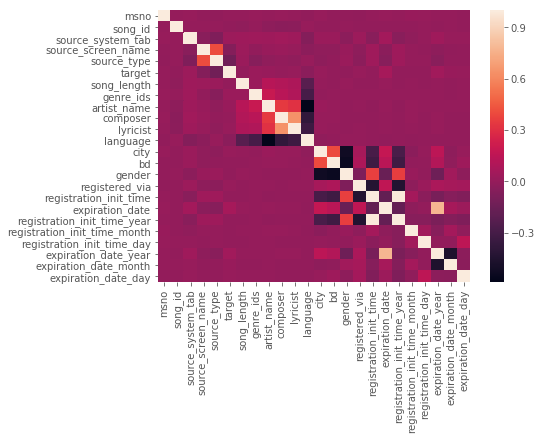

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
fig1 = sns.heatmap(df.corr())
plt.show()
#fig1 = plt.gcf()
#fig1.savefig('CoRelationMatrix.png')
fig = fig1.get_figure()
fig.savefig('CoRelationMatrix.png')

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [13]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

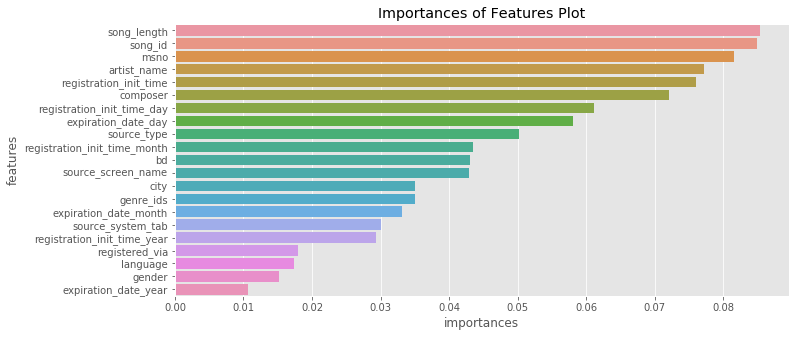

In [15]:
plt.figure(figsize=[11,5])
fig1 = sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()
#fig1 = plt.gcf()
#fig1.savefig('FeatureImportance.png', dpi=100)
fig = fig1.get_figure()
fig.savefig('FeatureImportance.png')

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

# XGBOOST

In [18]:
target = df.pop('target')
target

0        1
1        1
2        1
3        0
4        1
5        1
6        0
7        1
8        0
9        1
10       0
11       1
12       0
13       0
14       0
15       1
16       0
17       1
18       0
19       0
20       1
21       1
22       0
23       0
24       1
25       1
26       1
27       1
28       0
29       0
        ..
73744    0
73745    0
73746    1
73747    0
73748    0
73749    0
73750    0
73751    1
73752    0
73753    1
73754    0
73755    1
73756    0
73757    0
73758    1
73759    0
73760    0
73761    1
73762    1
73763    0
73764    1
73765    0
73766    1
73767    1
73768    1
73769    1
73770    0
73771    1
73772    1
73773    1
Name: target, Length: 73774, dtype: int64

In [19]:
# Train & Test split
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [20]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=5, missing=None,
       n_estimators=250, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [21]:
# Predicting
predict_labels = model.predict(test_data)

In [22]:
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60     10972
           1       0.62      0.65      0.63     11161

   micro avg       0.62      0.62      0.62     22133
   macro avg       0.62      0.62      0.62     22133
weighted avg       0.62      0.62      0.62     22133

